<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
'Kr DST' Study</p><br>

# Reads an analysis DST from FLEX data and plots resolution and others

In [155]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [156]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# Specific IC stuff
import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


In [157]:
from nextflex.krypton_dst import get_evt_true_positions_and_energy
from nextflex.krypton_dst import NN

In [158]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

# Code

In [187]:
def histo_var(df, var, varmin, varmax, bins=10, alpha=0.6, color='g'):
    df1 = df[df[var] < varmax]
    df2 = df1[df1[var] > varmin]
    plt.hist(df2[var].values, bins=bins, alpha=alpha, color=color)
    
def sigma(krdst, true='true_x', var='xmax', bins=10, alpha=0.6, color='g'):
    dx = (krdst[true] - krdst[var]).values
    mu, std = norm.fit(dx)
    plt.hist(dx, bins=bins, density=True, alpha=alpha, color=color)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.show()

    
def histo_s1(s1fid = 200, bins=100, alpha=0.6, color='g'):
    
    s1df = krdst[krdst.S1e < s1fid]
    plt.hist(s1df.S1e.values, bins=bins, density=True, alpha=alpha, color=color)
    plt.show()
    

In [292]:
def resolution(krdst, xlim, bins=100, figsize=(10,10),  alpha=0.6, pitch=15):
    """Plots the resolution for Krypton: (xmax-xtrue), (xpos-xtrue), same for y"""
    
    fig = plt.figure(figsize=figsize)
    
    varx =['xmax','xpos','ymax','ypos']
    vtru =['true_x','true_x','true_y','true_y']
    
    xmin = xlim[0]
    xmax = xlim[1]
    
    
    for i,var in enumerate(varx):
        ax      = fig.add_subplot(2, 2, i+1)
        vt = vtru[i]
        kfid = krdst[in_range(krdst[vt] - krdst[var], xmin, xmax)]
        dx = (kfid[vt] - kfid[var])
        hx = (krdst[vt] - krdst[var])
        
        if var == 'xpos' or var == 'ypos':
            mu, std = norm.fit(dx)
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            plt.plot(x, p, 'k', linewidth=2)
        else:
            std = pitch/np.sqrt(12)
        
        plt.hist(hx, bins=bins, density=True, range=(-20,20),
                 alpha=alpha, label=f'\u03C3 = {std:5.2f} mm')
        plt.xlabel(f'{var} (mm)')
        plt.legend(loc='upper left')
    plt.show()


In [257]:
def q_sipm(krdst,  bins=100, figsize=(10,10), alpha=0.6):
    """Plots the qmax, ql,qr,qu,qd"""
    
    Q = ['ql','qr','qu','qd']
    fig = plt.figure(figsize=figsize)
    
    ax      = fig.add_subplot(1, 2, 1)
    plt.hist(krdst.qmax, bins=bins, density=True, alpha=alpha, label=f'qmax')
    plt.legend()
    ax      = fig.add_subplot(1, 2, 2)
    for q in Q:
        plt.hist(krdst[q], bins=bins, density=True, alpha=alpha, label=f'{q}')
        plt.legend(loc='upper left')
    
    plt.show()


# Study of TP response

### 3+2

In [284]:
dirs =['flex3+2','flex15+3', 'flex15+8', 'flex15+6'] # defines where the SiPM plane is located and the thickness of the mask
i = 0
iPATH = f"/Users/jj/Development/demoData/{dirs[i]}"
krdst = pd.read_csv(f'{iPATH}/krdst.csv')
print(f'Configuration = {dirs[i]}')

Configuration = flex3+2


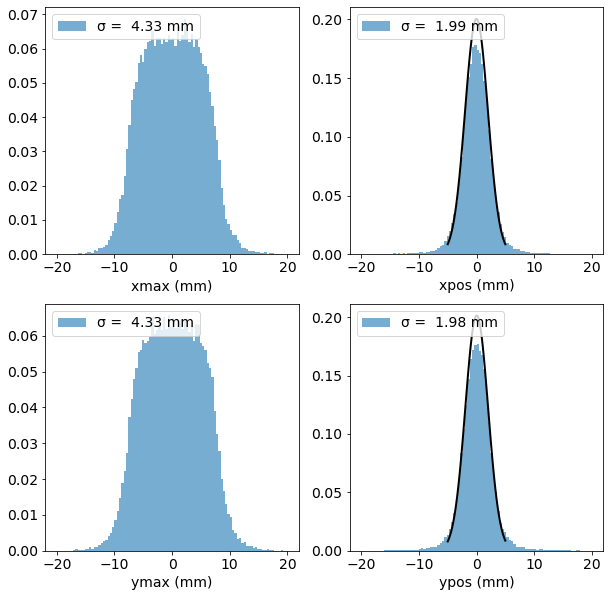

In [293]:
resolution(krdst, xlim=(-5,5), bins=100, figsize=(10,10), alpha=0.6)

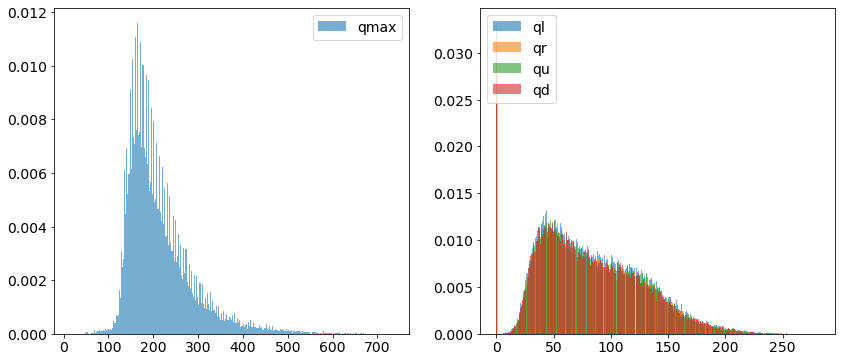

In [274]:
q_sipm(krdst,  bins=300, figsize=(14,6), alpha=0.6)

### 15+ 8 (15 mm distance 8 mm masks)

In [294]:
iPATH = f"/Users/jj/Development/demoData/{dirs[2]}"

In [295]:
krdst = pd.read_csv(f'{iPATH}/krdst.csv')

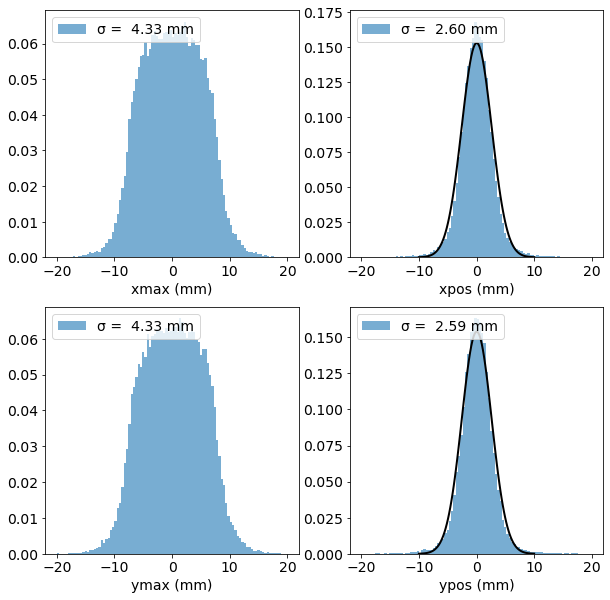

In [296]:
resolution(krdst, xlim=(-10,10), bins=100, figsize=(10,10), alpha=0.6)

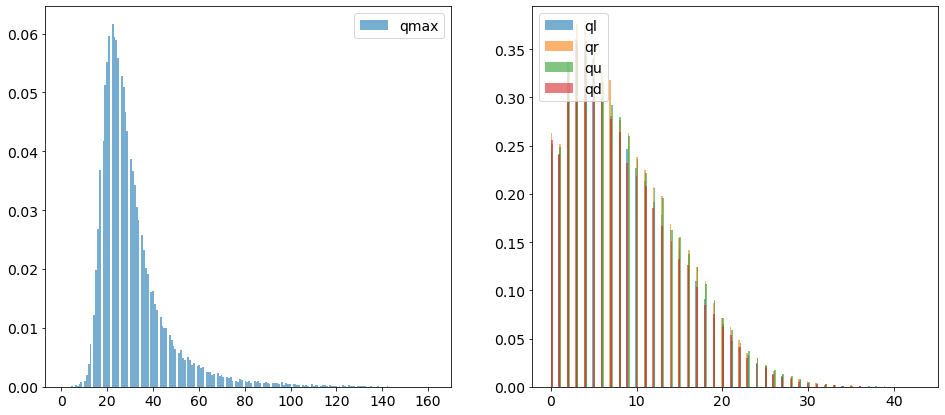

In [297]:
q_sipm(krdst,  bins=200, figsize=(16,7), alpha=0.6)

### 15+6

In [298]:
iPATH = f"/Users/jj/Development/demoData/{dirs[3]}"

In [299]:
krdst = pd.read_csv(f'{iPATH}/krdst.csv')

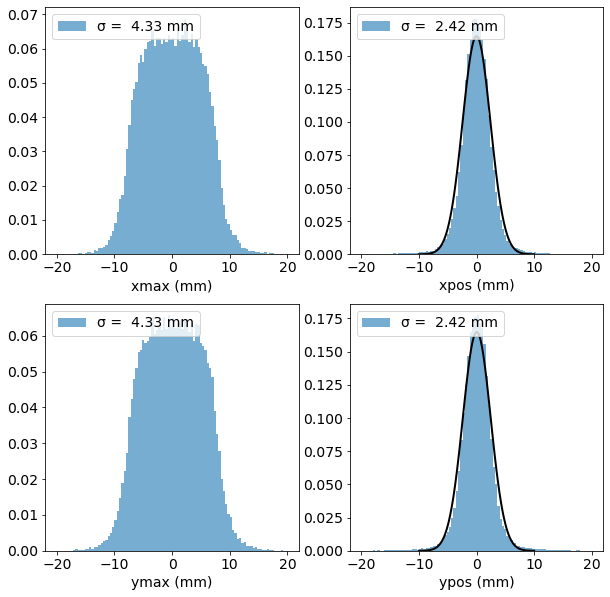

In [300]:
resolution(krdst, xlim=(-10,10), bins=100, figsize=(10,10), alpha=0.6)

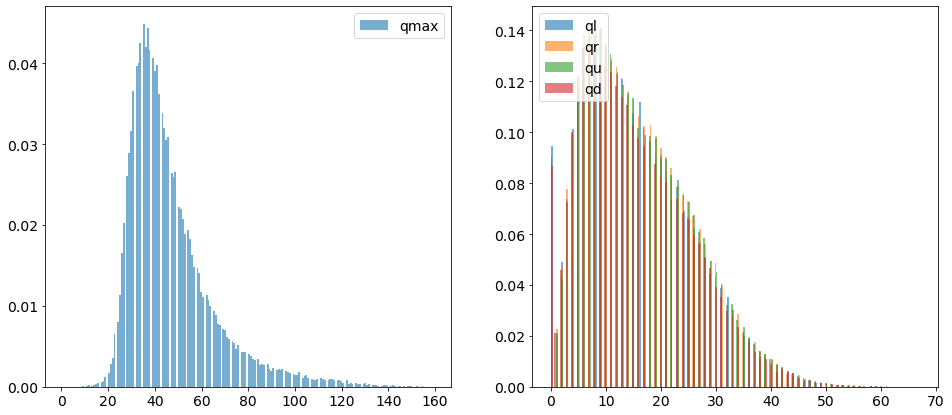

In [301]:
q_sipm(krdst,  bins=200, figsize=(16,7), alpha=0.6)

### 15+0 (15 mm distance 0 mm masks)

In [302]:
iPATH = f"/Users/jj/Development/demoData/{dirs[1]}"

In [303]:
krdst = pd.read_csv(f'{iPATH}/krdst.csv')

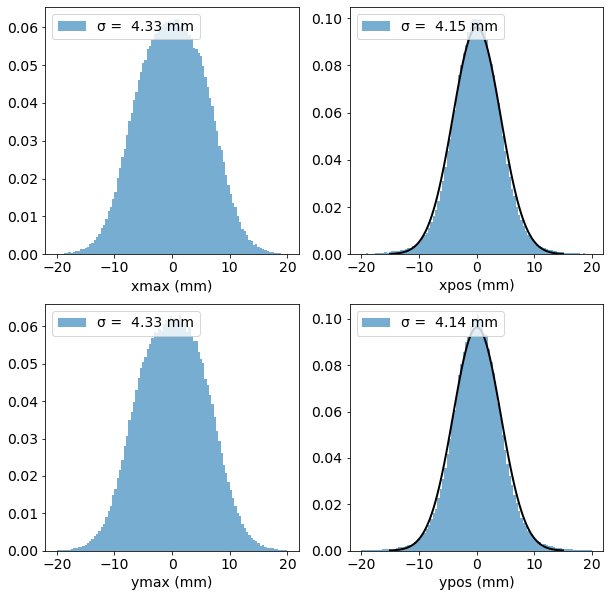

In [304]:
resolution(krdst, xlim=(-15,15), bins=100, figsize=(10,10), alpha=0.6)

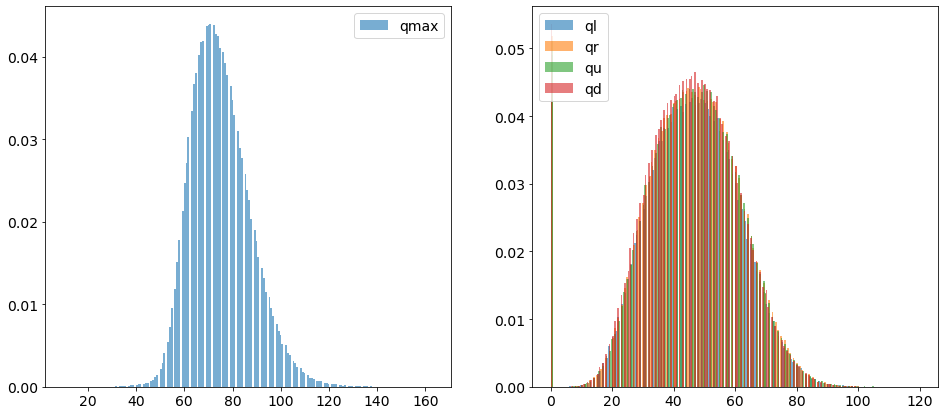

In [305]:
q_sipm(krdst,  bins=200, figsize=(16,7), alpha=0.6)